<a href="https://colab.research.google.com/github/flpsantoro/SPRINT_IV_PUC_ENG_SOFTWARE/blob/main/Notebook/SPRINT_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise e Classificação de Dados Zoológicos

Este notebook apresenta uma análise e classificação de dados zoológicos. Usaremos várias técnicas de aprendizado de máquina para prever a classificação de animais baseados em suas características. O processo envolve a preparação dos dados, definição de modelos, otimização de hiperparâmetros e avaliação dos modelos.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.pipeline import Pipeline
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns


## Carregamento dos Dados

Carregamos dois conjuntos de dados: um contendo informações sobre diferentes classes de animais e outro com características específicas de cada animal. O objetivo é usar essas características para prever a classificação do animal.


In [3]:
class_data = pd.read_csv('datasets/class.csv')
zoo_data = pd.read_csv('datasets/zoo.csv')

class_data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/class.csv'

In [ ]:
zoo_data.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


## Preparação dos Dados

Nesta etapa, preparamos os dados para o treinamento dos modelos. Removemos a coluna de nomes dos animais, pois não é relevante para a classificação. Em seguida, separamos os dados em características (X) e rótulos (y), e dividimos em conjuntos de treino e teste.


In [ ]:
zoo_data_clean = zoo_data.drop('animal_name', axis=1)
X = zoo_data_clean.drop('class_type', axis=1)
y = zoo_data_clean['class_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Definição dos Pipelines e Parâmetros para Otimização

Configuramos pipelines para diferentes modelos de aprendizado de máquina. Cada pipeline inclui uma etapa de normalização dos dados seguida pela definição do modelo. Também definimos os parâmetros para a otimização usando GridSearchCV.


In [ ]:
pipelines = {
    "Decision Tree": Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeClassifier())]),
    "Random Forest": Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier())]),
    "Logistic Regression": Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())]),
    "SVM": Pipeline([('scaler', StandardScaler()), ('model', SVC())]),
    "KNN": Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())]),
    "Naive Bayes": Pipeline([('scaler', StandardScaler()), ('model', GaussianNB())])
}

param_grids = {
    "Decision Tree": {'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10]},
    "Random Forest": {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5]},
    "Logistic Regression": {'model__C': [0.1, 1, 10]},
    "SVM": {'model__C': [0.1, 1, 10], 'model__gamma': [0.001, 0.01]},
    "KNN": {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']},
    "Naive Bayes": {}
}

## Otimização de Hiperparâmetros

Para cada modelo, realizamos uma busca em grade para encontrar os melhores hiperparâmetros. Isso é feito usando toda a base de dados. Os modelos otimizados são armazenados para avaliação posterior.


In [ ]:
optimized_models = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=4, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)  # Note que estamos usando todo o conjunto de dados aqui
    optimized_models[name] = grid_search.best_estimator_

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


## Avaliação dos Modelos

Avaliamos os modelos otimizados usando validação cruzada. Calculamos a acurácia, recall e pontuação F1 para cada modelo. Esses resultados nos ajudam a entender o desempenho de cada abordagem.


In [ ]:
cv_scores = {}
for name, model in optimized_models.items():
    accuracy = cross_val_score(model, X, y, cv=4, scoring=make_scorer(accuracy_score))
    recall = cross_val_score(model, X, y, cv=4, scoring=make_scorer(recall_score, average='weighted'))
    f1 = cross_val_score(model, X, y, cv=4, scoring=make_scorer(f1_score, average='weighted'))

    cv_scores[name] = {
        'CV Accuracy Mean': np.mean(accuracy),
        'CV Recall Mean': np.mean(recall),
        'CV F1 Score Mean': np.mean(f1)
    }

## Exibição dos Resultados

Apresentamos os resultados da avaliação dos modelos em um dataframe para fácil visualização e comparação.


In [ ]:
df_cv_scores = pd.DataFrame(cv_scores).T
print(df_cv_scores)

                     CV Accuracy Mean  CV Recall Mean  CV F1 Score Mean
Decision Tree                0.920385        0.930385          0.918718
Random Forest                0.930385        0.930385          0.919923
Logistic Regression          0.940385        0.940385          0.933257
SVM                          0.950385        0.950385          0.944469
KNN                          0.940385        0.940385          0.933257
Naive Bayes                  0.921154        0.921154          0.910138


## Visualização dos Resultados

Utilizamos um gráfico de barras para visualizar a acurácia média dos modelos com validação cruzada. Isso fornece uma comparação visual clara do desempenho dos diferentes modelos.


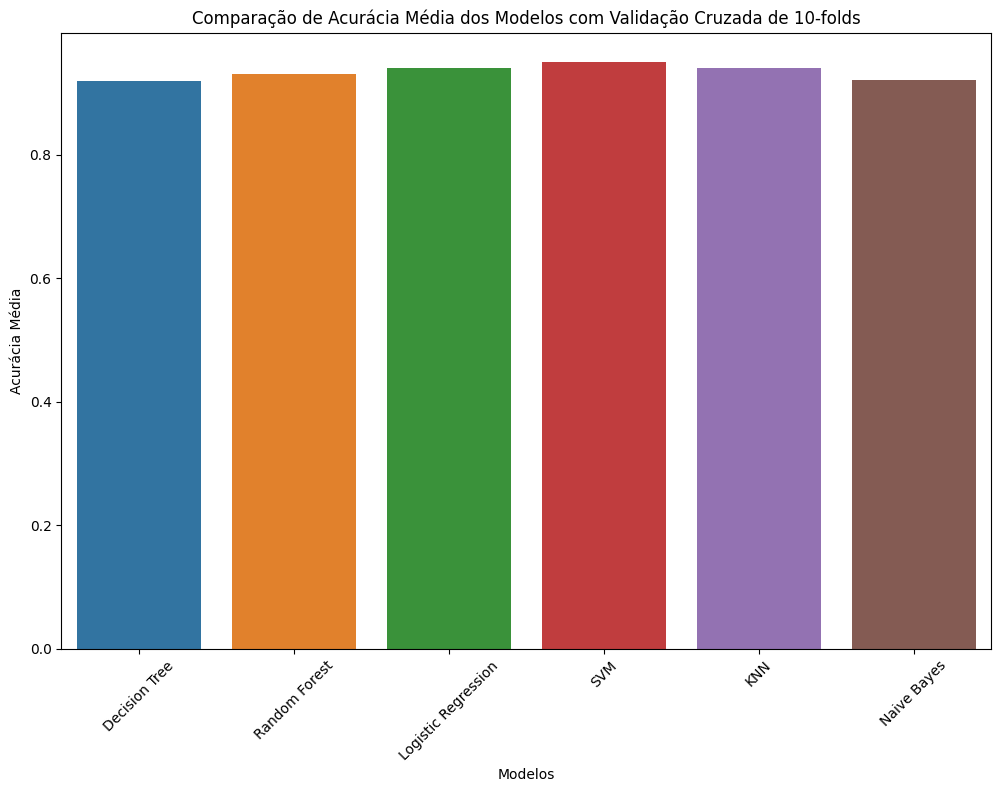

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x=df_cv_scores.index, y=df_cv_scores['CV Accuracy Mean'])
plt.title('Comparação de Acurácia Média dos Modelos com Validação Cruzada de 10-folds')
plt.ylabel('Acurácia Média')
plt.xlabel('Modelos')
plt.xticks(rotation=45)
plt.show()

## Exportação do Melhor Modelo

Finalmente, identificamos e exportamos o melhor modelo com base na acurácia média da validação cruzada. Isso permite o uso do modelo em aplicações futuras.


In [ ]:
best_model_name = max(cv_scores, key=lambda name: cv_scores[name]['CV Accuracy Mean'])
best_model = optimized_models[best_model_name]
model_filename = f'{best_model_name.lower()}_optimized_model.joblib'
dump(best_model, model_filename)

['svm_optimized_model.joblib']